<a href="https://colab.research.google.com/github/24092/Proyecto-Taller-Etapa-1/blob/main/Revision_Proyecto_final_Etapa_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Author: [Johan Rodríguez](https://github.com/Johanx22x)

Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [2]:
!pip install face_recognition         # Install face_recognition package using pip
import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot
from datetime import datetime

import pickle

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output

# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

# Utils

## In-memory data

In [3]:
registered_faces = {}
all_registered_face = {}
all_registered_faces= {}

# Mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# face recognition

In [5]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

# Real time streaming

In [6]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [7]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register Faces

In [15]:

# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]


upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)

# clases

In [9]:

class Person():
    """ La clase Person se crea """
    def __init__(self, ID, name, birthdate, Nationality, Telephone_numbers, Emails, Address):
        self.ID = ID
        self.name = name
        self.birthdate = birthdate
        self.Nationality = Nationality
        self.Telephone_numbers = Telephone_numbers
        self.Emails = Emails
        self.Address = Address

    def __str__(self):
        return "ID: {}, name: {}, Birthdate: {}, Nationality: {}, Telephone_numbers: {}, Emails: {}, Address: {}".format(
            self.ID, self.name, self.birthdate, self.Nationality, self.Telephone_numbers, self.Emails, self.Address
        )

class Professor(Person):
    """ Clase Professor que hereda de la clase Person """
    def __init__(self, ID, name, birthdate, Nationality, Telephone_numbers, Emails, Address, Specialty, age, civil_status):
        """ Constructor de la clase Professor """
        super().__init__(ID, name, birthdate, Nationality, Telephone_numbers, Emails, Address)
        self.Specialty = Specialty
        self.age = age
        self.civil_status = civil_status

    def __str__(self):
        """ Muestra la información de la clase """
        return super().__str__() + " Specialty: {}, age: {}, civil_status: {}".format(
            self.Specialty, self.age, self.civil_status
        )

class Student(Person):
    """ Clase Student que hereda de la clase Person """
    def __init__(self, ID, name, birthdate, Nationality, Telephone_numbers, Emails, Address, college_career, age, civil_status):
        """ Constructor de la clase Student """
        super().__init__(ID, name, birthdate, Nationality, Telephone_numbers, Emails, Address)
        self.college_career = college_career
        self.age = age
        self.civil_status = civil_status

    def __str__(self):
        """ Muestra la información de la clase """
        return super().__str__() + " college career: {}, age: {}, civil_status: {}".format(
            self.college_career, self.age, self.civil_status
        )

class Miscellaneous(Person):
    """ Clase Miscellaneous que hereda de la clase Person """
    def __init__(self, ID, name, birthdate, Nationality, Telephone_numbers, Emails, Address, work_shift, age, civil_status):
        """ Constructor de la clase Miscellaneous """
        super().__init__(ID, name, birthdate, Nationality, Telephone_numbers, Emails, Address)
        self.age = age
        self.civil_status = civil_status
        self.work_shift = work_shift

    def __str__(self):
        """ Muestra la información de la clase """
        return super().__str__() + " work_shift: {}, age: {}, civil_status: {}".format(
            self.work_shift, self.age, self.civil_status
        )

class Classroom():
    """ Clase creada para aulas """
    def __init__(self, classroom_number, miscellaneous):
        self.classroom_number = classroom_number
        self.miscellaneous = miscellaneous

    def __str__(self):
        return "classroom_number: {}, miscellaneous: {}".format(
            self.classroom_number, self.miscellaneous
        )

class AssistanceReport():
    """ Clase creada para informes de asistencia """
    def __init__(self, name, image_path, date_and_time):
        self.name = name
        self.image_path = image_path
        self.date_and_time = date_and_time

    def __str__(self):
        return "Name: {}, Image_path: {}, Date and time: {}".format(
            self.name, self.image_path, self.date_and_time
        )

class Courses:
    def __init__(self, code, name, semester, career, professor_name, student_name, classroom_number):
        self.code = code
        self.name = name
        self.semester = semester
        self.career = career
        self.professor_name = professor_name
        self.student_name = student_name
        self.classroom_number = classroom_number
    def __str__(self):
        return "code: {}, name: {}, semester: {}, career: {}, Professor: {}, students: {}, classroom: {}".format(
            self.code, self.name, self.semester, self.career, self.professor_name, self.student_name, self.classroom_number
        )



## Arbol binario: consulta 7 y 8

In [20]:

class Nodo():
    """Clase Nodo"""

    def __init__(self, person):
        self.izquierdo  = None
        self.derecho    = None
        self.person   = person

class Arbol():
    """Clase Arbol"""

    def __init__(self):
        self.raiz = None

    def insertar(self, person):
        if self.raiz == None:
            self.raiz = Nodo(person)
        else:
            self._insertar(person, self.raiz)

    def _insertar(self, person, nodo):
        if person.age < nodo.person.age:
            if nodo.izquierdo != None:
                self._insertar(person,nodo.izquierdo)
            else:
                nodo.izquierdo = Nodo(person)
        else:
            if nodo.derecho != None:
                self._insertar(person, nodo.derecho)
            else:
                nodo.derecho = Nodo(person)

    def en_orden(self, nodo):
        if nodo == None:
            return None
        else:
            self.en_orden(nodo.izquierdo)
            print( print("ID:",nodo.person.ID, "name:", nodo.person.name, "age:", nodo.person.age,"birthdate:", nodo.person.birthdate, "Nationality:",nodo.person.Nationality, "Telephones:",nodo.person.Telephone_numbers, "Emails:", nodo.person.Emails,"Address:", nodo.person.Address, "career:", nodo.person.college_career, "civil status:", nodo.person.civil_status))
            self.en_orden(nodo.derecho)

    def en_pre_orden(self, nodo):
        if nodo == None:
            return None
        else:
            print("ID:",nodo.person.ID, "name:", nodo.person.name, "age:", nodo.person.age,"birthdate:", nodo.person.birthdate, "Nationality:",nodo.person.Nationality, "Telephones:",nodo.person.Telephone_numbers, "Emails:", nodo.person.Emails,"Address:", nodo.person.Address, "career:", nodo.person.college_career, "civil status:", nodo.person.civil_status)
            self.en_pre_orden(nodo.izquierdo)
            self.en_pre_orden(nodo.derecho)

    def en_post_orden(self, nodo):
        if nodo == None:
            return None
        else:
            self.en_post_orden(nodo.izquierdo)
            self.en_post_orden(nodo.derecho)
            print(nodo.person.name)

    def buscar(self, nodo, person):
        if nodo == None:
            return None
        else:
            if person.name == nodo.persona.name:
                return nodo.persona
            else:
                if person.age < nodo.persona.age:
                    return self.buscar(nodo.izquierdo, person)
                else:
                    return self.buscar(nodo.derecho, person)


In [21]:
import pickle

# Assuming your Student class and Arbol class are defined as before

def cargar_estudiantes_desde_archivo():
    students = []
    with open("Student.bin", "rb") as f:
        while True:
            try:
                student = pickle.load(f)
                students.append(student)
            except EOFError:
                break
    return students

def insertar_estudiantes_en_arbol(arbol, estudiantes):
    student=[]
    for estudiante in estudiantes:
        arbol.insertar(estudiante)
        student.append(student)

# Crear el árbol
mi_arbol = Arbol()

# Cargar estudiantes desde el archivo binario
estudiantes = cargar_estudiantes_desde_archivo()

# Insertar estudiantes en el árbol
insertar_estudiantes_en_arbol(mi_arbol, estudiantes)

# Mostrar el árbol en orden
mi_arbol.en_orden(mi_arbol.raiz)

mi_arbol.en_pre_orden(mi_arbol.raiz)


ID: 1 name: Joshua age: 1 birthdate: 1 Nationality: 1 Telephones: {'home phone': '1', 'Cell phone ': '1'} Emails: 1 Address: 1 career: 1 civil status: 1
None
ID: 4 name: Joshua age: 4 birthdate: 4 Nationality: 4 Telephones: {'home phone': '4', 'Cell phone ': '4'} Emails: 4 Address: 4 career: 4 civil status: 4
None
ID: 1 name: Joshua age: 1 birthdate: 1 Nationality: 1 Telephones: {'home phone': '1', 'Cell phone ': '1'} Emails: 1 Address: 1 career: 1 civil status: 1
ID: 4 name: Joshua age: 4 birthdate: 4 Nationality: 4 Telephones: {'home phone': '4', 'Cell phone ': '4'} Emails: 4 Address: 4 career: 4 civil status: 4


# saca bin

In [10]:
'''functions that allow you to read the data saved in the binary files, function for teacher, student, micelane'''
def teacher_list ():
  with open("Professor.bin", "rb") as f:
      # Leer todas las instancias almacenadas en el archivo
      while True:
          try:
              professor = pickle.load(f)
              # Haz algo con la instancia deserializada, por ejemplo, imprime el nombre
              print("Professor information:", professor.name, "ID: ", professor.ID, "Birthdate: ", professor.birthdate, "Nationality:", professor.Nationality, "Telephone numbers: ", professor.Telephone_numbers, "Imails: ", professor.Emails, "Address: ", professor.Address, "Specialty: ",professor.Specialty, "Age: ",professor.age, "civil status: " ,professor.civil_status)

          except EOFError:
              # Cuando se alcanza el final del archivo, se lanza EOFError, por lo que se sale del bucle
              break

def miscellaneous_list ():
  with open("Miscellaneous.bin", "rb") as f:
      # Leer todas las instancias almacenadas en el archivo
      while True:
          try:
              miscellaneous = pickle.load(f)
              # Haz algo con la instancia deserializada, por ejemplo, imprime el nombre
              print("Micellaneous information:", miscellaneous.name, "ID: ", miscellaneous.ID, "Birthdate: ", miscellaneous.birthdate, "Nationality: ", miscellaneous.Nationality, "Telephone numbers: ", miscellaneous.Telephone_numbers, "Imails: ", miscellaneous.Emails, "Address: ", miscellaneous.Address, "work shift:",miscellaneous.work_shift, "Age: ",miscellaneous.age, "civil status:" ,miscellaneous.civil_status)

          except EOFError:
              # Cuando se alcanza el final del archivo, se lanza EOFError, por lo que se sale del bucle
              break

          except pickle.UnpicklingError:
            print("ocurrio un error, corrala la celda de clases y la de leer bin e intente nuevamente.")
            break
def classroom_list():
  with open("Classroom.bin", "rb") as f:
      # Leer todas las instancias almacenadas en el archivo
      while True:
          try:
              classroom = pickle.load(f)
              # Haz algo con la instancia deserializada, por ejemplo, imprime el nombre
              print("Informacion del Aula:",classroom.classroom_number , "Miscelaneo: ", classroom.miscellaneous)

          except EOFError:
              # Cuando se alcanza el final del archivo, se lanza EOFError, por lo que se sale del bucle
              break

          except pickle.UnpicklingError:
            print("ocurrio un error, corrala la celda de clases y la de leer bin e intente nuevamente.")
            break
def course_list():
  cur =load_data_from_file("courses.bin", Courses)
  cont=1
  cont1=1
  for c in cur:
    print("curso",cont)
    print()
    print("codigo del curso: ",c.code)
    print()
    print("nombre del curso: ", c.name)
    print()
    print("semestre que se imparte: ",c.semester)
    print()
    print("Carrera a la que pertenece: ", c.career)
    print()
    profe = c.Professor
    print("Profesores que imparten el curso: ")
    print()
    for prof in profe:
      print("Profe", cont1)
      print()
      for x, y in prof.items():
        print(x,y)
        print()
      cont1+=1
    cont1=1
    print("Estudiantes que llevan el curso: ")
    Stu = c.student
    for estu in Stu:
      for x, y in estu.items():
        print(x,y)
        print()
    print("Se imparte en el aula: ")
    print()
    cla = c.classroom
    for clasrom in cla:
      for x, y in clasrom.items():
        print(x,y)
        print()



    cont+=1

def bubble_sort_students_by_age(students):
    n = len(students)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            age1 = students[j].age
            age2 = students[j + 1].age
            if age1 > age2:
                students[j], students[j + 1] = students[j + 1], students[j]

def student_list():

    students = []
    with open("Student.bin", "rb") as f:
        while True:
            try:
                student = pickle.load(f)
                students.append(student)
            except EOFError:
                break

    bubble_sort_students_by_age(students)

    for student in students:
        print("Student information:")
        print("Name:", student.name)
        print("ID:", student.ID)
        print("Birthdate:", student.birthdate)
        print("Nationality:", student.Nationality)
        print("Telephone numbers:", student.Telephone_numbers)
        print("Emails:", student.Emails)
        print("Address:", student.Address)
        print("College career:", student.college_career)
        print("Age:", student.age)
        print("Civil status:", student.civil_status)
        print()  # Agrega una línea en blanco entre cada estudiante


def bubble_sort_students_by_age_desc(students):
    n = len(students)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            age1 = students[j].age
            age2 = students[j + 1].age
            if age1 < age2:
                students[j], students[j + 1] = students[j + 1], students[j]

def student_list_desc():
    students = []
    with open("Student.bin", "rb") as f:
        while True:
            try:
                student = pickle.load(f)
                students.append(student)
            except EOFError:
                break

    bubble_sort_students_by_age_desc(students)

    for student in students:
        print("Student information:")
        print("Name:", student.name)
        print("ID:", student.ID)
        print("Birthdate:", student.birthdate)
        print("Nationality:", student.Nationality)
        print("Telephone numbers:", student.Telephone_numbers)
        print("Emails:", student.Emails)
        print("Address:", student.Address)
        print("College career:", student.college_career)
        print("Age:", student.age)
        print("Civil status:", student.civil_status)
        print()  # Agrega una línea en blanco entre cada estudiante



def print_course_info(file_name):
    try:
        # Abre el archivo binario en modo lectura
        with open(file_name, "rb") as file:
            # Carga la instancia de la clase "courses" desde el archivo
            course_instance = pickle.load(file)

            # Imprime el nombre del curso
            print("Nombre del curso:", course_instance.name)

            # Imprime la información del profesor
            professor_info = course_instance.Professor[0]
            print("Información del Profesor:")
            for key, value in professor_info.items():
                print(f"{key}: {value}")

    except FileNotFoundError:
        print(f"El archivo {file_name} no se encontró.")
    except Exception as e:
        print(f"Ocurrió un error al procesar el archivo: {str(e)}")



#AGREGAR

In [11]:
import pickle
import ipywidgets as widgets


def find_classroom_by_number(file_name, classroom_number):
    instances = []

    with open(file_name, "rb") as f:
        try:
            while True:
                instance = pickle.load(f)
                instances.append(instance)
        except EOFError:
            pass

    for instance in instances:
        # Suponiendo que la clase Classroom tiene un atributo 'number'
        if instance.number == classroom_number:
            return instance

    return None

# Supongamos que tienes las definiciones de las clases Professor, Student, Classroom y Courses aquí...

def find_instance_by_name(file_name, class_type, name):
    instances = []

    with open(file_name, "rb") as f:
        try:
            while True:
                instance = pickle.load(f)
                instances.append(instance)
        except EOFError:
            pass

    for instance in instances:
        if instance.name == name:
            return instance

    return None
def check_existence(file_path, target_name):
    try:
        with open(file_path, "rb") as f:
            while True:
                instance = pickle.load(f)
                if target_name == instance.name:
                    return True
    except FileNotFoundError:
        return False
    except EOFError:
        pass
    return False

def create_classroom(button):
    classroom_number = classroom_number_widget.value
    miscellaneous = miscellaneous_widget.value
    working_hours = working_hours_widget.value

    instances = []

    with open("Miscellaneous.bin", "rb") as f:
        try:
            while True:
                instance = pickle.load(f)
                instances.append(instance)
        except EOFError:
            pass

    for instance in instances:
        if miscellaneous == instance.name:
            # Utiliza toda la instancia de Miscellaneous en lugar de solo el nombre
            classroom_instance = Classroom(classroom_number, instance)

            with open("Classroom.bin", "ab") as f:
                pickle.dump(classroom_instance, f, pickle.HIGHEST_PROTOCOL)
            print("Successfully added")
            break
    else:
        print("The miscellaneous doesn't exist. Try again")

def create_courses(button):
    code = code_widget.value
    name = name_widget_c.value
    semester = semester_widget.value
    career = career_widget_c.value
    professor_name = professor_name_widget.value
    student_name = student_name_widget.value
    classroom_number_c= classroom_number_widget_c.value

    courses = Courses(code, name, semester, career, professor_name, student_name, classroom_number_c)
    with open("Courses.bin", "ab") as f:
        pickle.dump(courses, f, pickle.HIGHEST_PROTOCOL)
    print("successfully added")



classroom_number_widget_c = widgets.Text(description='Number')
miscellaneous_widget = widgets.Text(description='Miscellaneous')
working_hours_widget = widgets.Text(description='Working Hours')
boton_create_classroom = widgets.Button(description='Generate Classroom')
output_classroom = widgets.Output()
boton_create_classroom.on_click(create_classroom)

code_widget = widgets.Text(description='Code:')
name_widget_c = widgets.Text(description='Name:')
semester_widget = widgets.Text(description='Semester:')
career_widget_c = widgets.Text(description='Career:')
professor_name_widget = widgets.Text(description='Professor')
student_name_widget = widgets.Text(description='Student')
classroom_number_widget = widgets.Text(description='Classroom')
boton_create_courses = widgets.Button(description='Generate Courses')
output_courses = widgets.Output()
boton_create_courses.on_click(create_courses)

widgets.VBox([
    widgets.Label(value='Classroom'),
    classroom_number_widget,
    miscellaneous_widget,
    working_hours_widget,
    boton_create_classroom,
    output_classroom,
    widgets.Label(value='Courses'),
    code_widget,
    name_widget_c,
    semester_widget,
    career_widget_c,
    professor_name_widget,
    student_name_widget,
    classroom_number_widget_c,
    boton_create_courses,
    output_courses,
])

Successfully added
successfully added


In [12]:

class MenuApp:
    def __init__(self):
        self.label = widgets.Label(value="Seleccione una opción para agregar:")
        self.options = ["register professor", "registered Student", "registered miscellaneous", "Exit"]
        self.dropdown = widgets.Dropdown(options=self.options, value=self.options[0], description="Options:")
        self.button = widgets.Button(description="Selec")
        self.output = widgets.Output()

        self.button.on_click(self.on_button_click)
        self.layout = widgets.VBox([self.label, self.dropdown, self.button, self.output])

    def on_button_click(self, b):
        selected_option = self.dropdown.value
        with self.output:
            clear_output(wait=True)
            if selected_option == "Exit":
                print("Saliendo...")
            else:
                self.handle_option(selected_option)

    def handle_option(self, selected_option):
      if selected_option == "register professor":
          self.add_professor_form()
      elif selected_option == "registered Student":
          self.add_student_form()
      elif selected_option == "registered miscellaneous":
          self.add_miscellaneous_form()
      else:
          print(f"Opción inválida: {selected_option}")

    def add_professor_form(self):
        ID_widget = widgets.Text(description='ID:')
        birthdate_widget = widgets.Text(description='Birthdate:')
        nationality_widget = widgets.Text(description='Nationality:')
        telephone_number_widget = widgets.Text(description='Home phone:')
        cell_phone_number_widget = widgets.Text(description='Cell phone:')
        emails_widget = widgets.Text(description='Emails:')
        address_widget = widgets.Text(description='Address:')
        specialty_widget = widgets.Text(description='Specialty:')
        age_widget = widgets.Text(description='Age:')
        civil_status_widget = widgets.Text(description='Civil status:')

        register_button = widgets.Button(description='registered Profesor')
        register_output = widgets.Output()

        def register_professor(button):
            ID = ID_widget.value
            name = registered_name
            birthdate = birthdate_widget.value
            nationality = nationality_widget.value
            telephone_number = telephone_number_widget.value
            cell_phone_number = cell_phone_number_widget.value
            telephone_numbers = {"home phone": telephone_number, "Cell phone": cell_phone_number}
            emails = emails_widget.value
            address = address_widget.value
            specialty = specialty_widget.value
            age = age_widget.value
            civil_status = civil_status_widget.value

            professor = Professor(ID, name, birthdate, nationality, telephone_numbers, emails, address, specialty, age, civil_status)

            with open("Professor.bin", "ab") as f:
                pickle.dump(professor, f, pickle.HIGHEST_PROTOCOL)
            all_registered_face=registered_faces[registered_name]
            all_registered_faces[registered_name] = all_registered_face
            print("successfully added")

        register_button.on_click(register_professor)

        display(widgets.VBox([
            widgets.Label(value='Teacher'),
            ID_widget,
            birthdate_widget,
            nationality_widget,
            telephone_number_widget,
            cell_phone_number_widget,
            emails_widget,
            address_widget,
            specialty_widget,
            age_widget,
            civil_status_widget,
            register_button,
            register_output,
        ]))
    def add_student_form(self):
      ID_widget = widgets.Text(description='ID:')
      birthdate_widget = widgets.Text(description='Birthdate:')
      Nationality_widget = widgets.Text(description='Nationality:')
      Telephone_number_widget = widgets.Text(description='home phone:')
      cell_phone_number_widget = widgets.Text(description = "Cell phone:")
      Emails_widget = widgets.Text(description='Emails:')
      Address_widget = widgets.Text(description='Address:')
      college_career_widget = widgets.Text(description='College career:')
      age_widget = widgets.Text(description='Age:')
      civil_status_widget = widgets.Text(description='Civil status:')

      register_button = widgets.Button(description='registered Student')
      register_output = widgets.Output()

      def create_student(button):
        ID = ID_widget.value
        name = registered_name
        birthdate = birthdate_widget.value
        Nationality = Nationality_widget.value
        Telephone_number = Telephone_number_widget.value
        cell_phone_number = cell_phone_number_widget.value
        Telephone_numbers = {"home phone": Telephone_number,
                            "Cell phone ": cell_phone_number,}
        Emails = Emails_widget.value
        Address = Address_widget.value
        college_career = college_career_widget.value
        age = age_widget.value
        civil_status = civil_status_widget.value

        student = Student(ID, name, birthdate, Nationality, Telephone_numbers, Emails, Address, college_career, age, civil_status)
        with open("Student.bin", "ab") as f:
            pickle.dump(student, f, pickle.HIGHEST_PROTOCOL)
        all_registered_face=registered_faces[registered_name]
        all_registered_faces[registered_name] = all_registered_face
        print ("successfully added")
      register_button.on_click(create_student)

      display(widgets.VBox([
          widgets.Label(value='Student'),
          ID_widget,
          birthdate_widget,
          Nationality_widget,
          Telephone_number_widget,
          cell_phone_number_widget,
          Emails_widget,
          Address_widget,
          college_career_widget,
          age_widget,
          civil_status_widget,
          register_button,
          register_output, ]))

    def add_miscellaneous_form(self):
        ID_widget = widgets.Text(description='ID:')
        birthdate_widget = widgets.Text(description='Birthdate:')
        nationality_widget = widgets.Text(description='Nationality:')
        telephone_number_widget = widgets.Text(description='Home phone:')
        cell_phone_number_widget = widgets.Text(description='Cell phone:')
        emails_widget = widgets.Text(description='Emails:')
        address_widget = widgets.Text(description='Address:')
        work_shift_widget = widgets.Text(description='Work shift:')
        age_widget = widgets.Text(description='Age:')
        civil_status_widget = widgets.Text(description='Civil status:')

        register_button = widgets.Button(description='registered miscellaneous')
        register_output = widgets.Output()
        def create_miscellaneous(button):
          ID = ID_widget.value
          name = registered_name
          birthdate = birthdate_widget.value
          Nationality = nationality_widget.value
          telephone_number = telephone_number_widget.value
          cell_phone_number = cell_phone_number_widget.value
          Telephone_numbers = {"home phone": telephone_number,
                              "Cell phone ": cell_phone_number,}
          emails = emails_widget.value
          address = address_widget.value
          work_shift = work_shift_widget.value
          age = age_widget.value
          civil_status = civil_status_widget.value
          miscellaneous = Miscellaneous(ID, name, birthdate, Nationality, Telephone_numbers, emails, address, work_shift, age, civil_status)
          with open("Miscellaneous.bin", "ab") as f:
              pickle.dump(miscellaneous, f, pickle.HIGHEST_PROTOCOL)
          print ("successfully added")
          all_registered_face=registered_faces[registered_name]
          all_registered_faces[registered_name] = all_registered_face
        register_button.on_click(create_miscellaneous)

        display(widgets.VBox([
            widgets.Label(value='Student'),
            ID_widget,
            birthdate_widget,
            nationality_widget,
            telephone_number_widget,
            cell_phone_number_widget,
            emails_widget,
            address_widget,
            work_shift_widget,
            age_widget,
            civil_status_widget,
            register_button,
            register_output, ]))


if __name__ == "__main__":
    app = MenuApp()
    display(app.layout)

successfully added
successfully added
successfully added


## Menú de consultas

Label(value="Professor information: name: Ronaldo, ID: 23, Birthdate: 23, Nationality: 23, Telephone numbers: …

Label(value="Professor information: name: Ronaldo, ID: 3, Birthdate: 3, Nationality: 3, Telephone numbers: {'h…

Label(value="Student information: Name: Joshua, ID: 1, Birthdate: 1, Nationality: 1, Telephone numbers: {'home…

Label(value="Student information: Name: Joshua, ID: 4, Birthdate: 4, Nationality: 4, Telephone numbers: {'home…

Label(value="Micellaneous information: Name: Kroos, ID: 4, Birthdate: 4, Nationality: 4, Telephone numbers: {'…

Label(value="Micellaneous information: Name: Kroos, ID: 44, Birthdate: 4, Nationality: 4, Telephone numbers: {…

Label(value="Classroom information: Classroom Number: 23, Miscellaneous: ID: 4, name: Kroos, Birthdate: 4, Nat…

Label(value="Classroom information: Classroom Number: 23, Miscellaneous: ID: 4, name: Kroos, Birthdate: 4, Nat…

Label(value='Course information: Code: 23, Name: calculo, Semester: 1, Career: computacion, Professor Name: Ro…

Label(value='Course information: Code: 23, Name: calculo, Semester: 2, Career: computacion, Professor Name: Ro…

<IPython.core.display.Javascript object>

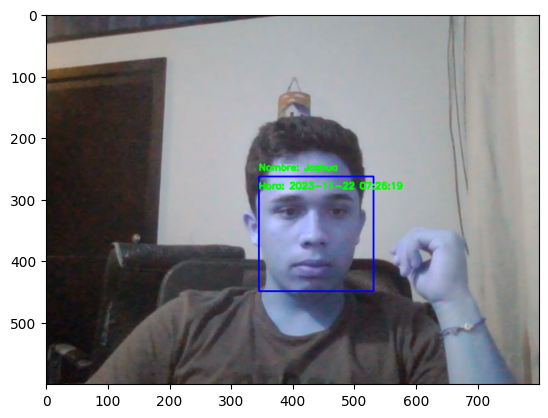

Joshua es la persona con más asistencias, asistió 1 veces al reporte.
Joshua es la persona con menos asistencias, asistió 1 veces al reporte.
Joshua es la persona con más asistencias, asistió 2 veces al reporte.
Student information:
Name: Joshua
ID: 1
Birthdate: 1
Nationality: 1
Telephone numbers: {'home phone': '1', 'Cell phone ': '1'}
Emails: 1
Address: 1
College career: 1
Age: 1
Civil status: 1

Joshua es la persona con menos asistencias, asistió 2 veces al reporte.
Student information:
Name: Joshua
ID: 1
Birthdate: 1
Nationality: 1
Telephone numbers: {'home phone': '1', 'Cell phone ': '1'}
Emails: 1
Address: 1
College career: 1
Age: 1
Civil status: 1



<IPython.core.display.Javascript object>

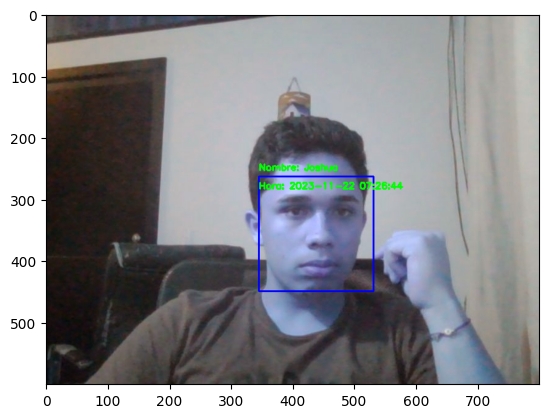

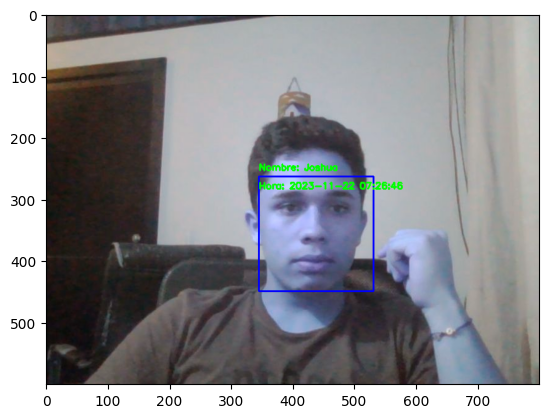

La fecha y hora en que más reportes hubo fue: 2023-11-22 07:26:46 con un total de 2 personas


HTML(value="<b>Classroom information:</b><br><b>Classroom Number:</b> 23<br><b>Miscellaneous:</b><br><table><t…

HTML(value="<b>Classroom information:</b><br><b>Classroom Number:</b> 23<br><b>Miscellaneous:</b><br><table><t…

In [22]:
import pickle
import ipywidgets as widgets
from IPython.display import display
import ipywidgets as widgets
from IPython.display import display

# Define your classes (Professor, Student, Miscellaneous, Classroom, Course)

def teacher_list(button):
    with open("Professor.bin", "rb") as f:
        while True:
            try:
                professor = pickle.load(f)
                display(widgets.Label(value=f"Professor information: name: {professor.name}, ID: {professor.ID}, Birthdate: {professor.birthdate}, Nationality: {professor.Nationality}, Telephone numbers: {professor.Telephone_numbers}, Emails: {professor.Emails}, Address: {professor.Address}, Specialty: {professor.Specialty}, Age: {professor.age}, civil status: {professor.civil_status}"))
            except EOFError:
                break

def student_list(button):
    students = []
    with open("Student.bin", "rb") as f:
        while True:
            try:
                student = pickle.load(f)
                students.append(student)
            except EOFError:
                break

    bubble_sort_students_by_age(students)

    for student in students:
        display(widgets.Label(value=f"Student information: Name: {student.name}, ID: {student.ID}, Birthdate: {student.birthdate}, Nationality: {student.Nationality}, Telephone numbers: {student.Telephone_numbers}, Emails: {student.Emails}, Address: {student.Address}, College career: {student.college_career}, Age: {student.age}, Civil status: {student.civil_status}"))

def miscellaneous_list(button):
    with open("Miscellaneous.bin", "rb") as f:
        while True:
            try:
                miscellaneous = pickle.load(f)
                display(widgets.Label(value=f"Micellaneous information: Name: {miscellaneous.name}, ID: {miscellaneous.ID}, Birthdate: {miscellaneous.birthdate}, Nationality: {miscellaneous.Nationality}, Telephone numbers: {miscellaneous.Telephone_numbers}, Emails: {miscellaneous.Emails}, Address: {miscellaneous.Address}, Work shift: {miscellaneous.work_shift}, Age: {miscellaneous.age}, Civil status: {miscellaneous.civil_status}"))
            except EOFError:
                break
            except pickle.UnpicklingError:
                display(widgets.Label(value="An error occurred. Please check the class cell and the bin read cell and try again."))
                break

def classroom_list(button):
    with open("Classroom.bin", "rb") as f:
        while True:
            try:
                classroom = pickle.load(f)
                display(widgets.Label(value=f"Classroom information: Classroom Number: {classroom.classroom_number}, Miscellaneous: {classroom.miscellaneous}"))
            except EOFError:
                break
            except pickle.UnpicklingError:
                display(widgets.Label(value="An error occurred. Please check the class cell and the bin read cell and try again."))
                break

def read_courses(button):
    try:
        with open("Courses.bin", "rb") as f:
            while True:
                try:
                    course = pickle.load(f)
                    display(widgets.Label(value=f"Course information: Code: {course.code}, Name: {course.name}, Semester: {course.semester}, Career: {course.career}, Professor Name: {course.professor_name}, Student Name: {course.student_name}, Classroom Number: {course.classroom_number}"))
                except EOFError:
                    break
    except FileNotFoundError:
        display(widgets.Label(value="File 'Courses.bin' not found."))

def consulta_6(button):
    import cv2
    from datetime import datetime

    # Inicializa algunas variables
    video_stream()

    label_html = 'Capturando...'
    bbox = ''
    i = 0
    photo_count = 0
    attendance_count = {}  # Diccionario para realizar un seguimiento de la asistencia

    while True:
        js_reply = video_frame(label_html, bbox)
        if not js_reply:
            break

        # Convierte la respuesta de JS en una imagen de OpenCV
        frame = js_to_image(js_reply["img"])

        # Obtiene las ubicaciones de los rostros en el cuadro
        face_locations = face_recognition.face_locations(frame)

        img_path = '/content/drive/MyDrive/proyecto_taller' + 'frame' + str(i) + '.jpg'
        cv2.imwrite(img_path, frame)

        # Para cada rostro en el cuadro
        for (top, right, bottom, left) in face_locations:
            # Dibuja un rectángulo alrededor del rostro
            cv2.rectangle(
                frame,
                (left, top),
                (right, bottom),
                (0, 0, 255),
                2,
            )

            # Obtiene la codificación del rostro
            face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

            # Compara la codificación del rostro con la base de datos de rostros registrados
            matches = face_recognition.compare_faces(list(all_registered_faces.values()), face_encoding)

            # Si hay una coincidencia
            if True in matches:
                # Obtiene el índice de la coincidencia
                match_index = matches.index(True)

                # Obtiene el nombre de la persona reconocida
                match_name = list(all_registered_faces.keys())[match_index]

                # Obtiene la hora y fecha actual
                current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                # Actualiza el contador de asistencia para esta persona
                if match_name in attendance_count:
                    attendance_count[match_name] += 1
                else:
                    attendance_count[match_name] = 1

                # Agrega texto a la imagen
                cv2.putText(frame, f"Nombre: {match_name}", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                cv2.putText(frame, f"Hora: {current_time}", (left, top + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Muestra la imagen
        plt.imshow(frame)
        plt.show()

        i +=1
        photo_count += 1

    if attendance_count:
        most_attended_person = max(attendance_count, key=attendance_count.get)
        least_attended_person = min(attendance_count, key=attendance_count.get)
        most_attendances = attendance_count[most_attended_person]
        least_attendances = attendance_count[least_attended_person]
        print(f"{most_attended_person} es la persona con más asistencias, asistió {most_attendances} veces al reporte.")
        print(f"{least_attended_person} es la persona con menos asistencias, asistió {least_attendances} veces al reporte.")
    else:
        print("No se reconoció a ninguna persona en el video.")



def crear_arbol(b):
    global mi_arbol
    mi_arbol = Arbol()
    actualizar_resultados()


def mostrar_en_orden(b):
    with output:
        print("Recorrido en orden:")
        mi_arbol.en_orden(mi_arbol.raiz)


def mostrar_pre_orden(b):
    with output:
        print("Recorrido en preorden:")
        mi_arbol.en_pre_orden(mi_arbol.raiz)


def actualizar_resultados():
    with output:
        print("Recorrido en orden:")
        mi_arbol.en_orden(mi_arbol.raiz)



def consulta_9(button):

    if attendance_count:
            most_attended_person = max(attendance_count, key=attendance_count.get)
            least_attended_person = min(attendance_count, key=attendance_count.get)
            most_attendances = attendance_count[most_attended_person]
            least_attendances = attendance_count[least_attended_person]

            print(f"{most_attended_person} es la persona con más asistencias, asistió {most_attendances} veces al reporte.")

    else:
        print("No se reconoció a ninguna persona en el video.")
    student_list1()


def consulta_10(button):

      if attendance_count:
          most_attended_person = max(attendance_count, key=attendance_count.get)
          least_attended_person = min(attendance_count, key=attendance_count.get)
          most_attendances = attendance_count[most_attended_person]
          least_attendances = attendance_count[least_attended_person]


          print(f"{least_attended_person} es la persona con menos asistencias, asistió {least_attendances} veces al reporte.")

      else:
            print("No se reconoció a ninguna persona en el video.")

      student_list1()


def consulta_11(button):
      import cv2
      from datetime import datetime

      # Inicializa algunas variables
      video_stream()

      label_html = 'Capturando...'
      bbox = ''
      i = 0
      photo_count = 0
      attendance_count = {}  # Diccionario para realizar un seguimiento de la asistencia

      while True:
          js_reply = video_frame(label_html, bbox)
          if not js_reply:
              break

          # Convierte la respuesta de JS en una imagen de OpenCV
          frame = js_to_image(js_reply["img"])

          # Obtiene las ubicaciones de los rostros en el cuadro
          face_locations = face_recognition.face_locations(frame)

          img_path = '/content/drive/MyDrive/proyecto_taller' + 'frame' + str(i) + '.jpg'
          cv2.imwrite(img_path, frame)

          # Para cada rostro en el cuadro
          for (top, right, bottom, left) in face_locations:
              # Dibuja un rectángulo alrededor del rostro
              cv2.rectangle(
                  frame,
                  (left, top),
                  (right, bottom),
                  (0, 0, 255),
                  2,
              )

              # Obtiene la codificación del rostro
              face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

              # Compara la codificación del rostro con la base de datos de rostros registrados
              matches = face_recognition.compare_faces(list(all_registered_faces.values()), face_encoding)

              # Si hay una coincidencia
              if True in matches:
                  # Obtiene el índice de la coincidencia
                  match_index = matches.index(True)

                  # Obtiene el nombre de la persona reconocida
                  match_name = list(all_registered_faces.keys())[match_index]

                  # Obtiene la hora y fecha actual
                  current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                  # Actualiza el contador de asistencia para esta persona
                  if match_name in attendance_count:
                      attendance_count[match_name] += 1
                  else:
                      attendance_count[match_name] = 1

                  # Agrega texto a la imagen
                  cv2.putText(frame, f"Nombre: {match_name}", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                  cv2.putText(frame, f"Hora: {current_time}", (left, top + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

          # Muestra la imagen
          plt.imshow(frame)
          plt.show()

          i +=1
          photo_count += 1

      if attendance_count:
          most_attended_person = max(attendance_count, key=attendance_count.get)
          least_attended_person = min(attendance_count, key=attendance_count.get)
          most_attendances = attendance_count[most_attended_person]
          least_attendances = attendance_count[least_attended_person]
          print("La fecha y hora en que más reportes hubo fue: " f"{current_time}","con un total de",photo_count,"personas")


def display_classroom_info(classroom):
    display(widgets.HTML(f"<b>Classroom information:</b><br>"
                          f"<b>Classroom Number:</b> {classroom.classroom_number}<br>"
                          f"<b>Miscellaneous:</b><br>"
                          f"<table>"
                          f"<tr><td>ID:</td><td>{classroom.miscellaneous.ID}</td></tr>"
                          f"<tr><td>Name:</td><td>{classroom.miscellaneous.name}</td></tr>"
                          f"<tr><td>Birthdate:</td><td>{classroom.miscellaneous.birthdate}</td></tr>"
                          f"<tr><td>Nationality:</td><td>{classroom.miscellaneous.Nationality}</td></tr>"
                          f"<tr><td>Telephone Numbers:</td><td>{classroom.miscellaneous.Telephone_numbers}</td></tr>"
                          f"<tr><td>Emails:</td><td>{classroom.miscellaneous.Emails}</td></tr>"
                          f"<tr><td>Address:</td><td>{classroom.miscellaneous.Address}</td></tr>"
                          f"<tr><td>Work Shift:</td><td>{classroom.miscellaneous.work_shift}</td></tr>"
                          f"<tr><td>Age:</td><td>{classroom.miscellaneous.age}</td></tr>"
                          f"<tr><td>Civil Status:</td><td>{classroom.miscellaneous.civil_status}</td></tr>"
                          f"</table><br>"))

def classroom_list2(button):
    with open("Classroom.bin", "rb") as f:
        while True:
            try:
                classroom = pickle.load(f)
                display_classroom_info(classroom)
            except EOFError:
                break
            except pickle.UnpicklingError:
                display(widgets.Label(value="An error occurred. Please check the class cell and the bin read cell and try again."))
                break



def bubble_sort_students_by_age(students):
    pass

# Create buttons
boton_teacher_list = widgets.Button(description="Show Teachers")
boton_student_list = widgets.Button(description="Show Students")
boton_miscellaneous_list = widgets.Button(description="Show Miscellaneous")
boton_classroom_list = widgets.Button(description="Show Classrooms")
boton_read_courses = widgets.Button(description="Read Courses")
boton_most_report_asis = widgets.Button(description="Asistence")
btn_orden = widgets.Button(description="Mostrar en Orden")
btn_preorden = widgets.Button(description="Mostrar Preorden")
boton_consulta_9 = widgets.Button(description="Most asistence")
boton_consulta_10 = widgets.Button(description="Low asistence")
boton_consulta_11 = widgets.Button(description="Most persons")
boton_classroom_list2 = widgets.Button(description="Miscellaneous in classrooms")


# Set up button click events
boton_teacher_list.on_click(teacher_list)
boton_student_list.on_click(student_list)
boton_miscellaneous_list.on_click(miscellaneous_list)
boton_classroom_list.on_click(classroom_list)
boton_read_courses.on_click(read_courses)
boton_most_report_asis.on_click(consulta_6)
btn_orden.on_click(mostrar_en_orden)
btn_preorden.on_click(mostrar_pre_orden)
boton_consulta_9.on_click(consulta_9)
boton_consulta_10.on_click(consulta_10)
boton_consulta_11.on_click(consulta_11)
boton_classroom_list2.on_click(classroom_list2)



# Display buttons and output widgets
output_teacher_list = widgets.Output()
output_student_list = widgets.Output()
output_miscellaneous_list = widgets.Output()
output_classroom_list = widgets.Output()
output_read_courses = widgets.Output()
output_most_report_asis = widgets.Output()
output = widgets.Output()

output_consulta_9 = widgets.Output()
output_consulta_10 = widgets.Output()
output_consulta_11 = widgets.Output()
output_classroom_list2= widgets.Output()


display(widgets.VBox([
    widgets.Label(value='Teachers instances'),
    boton_teacher_list,
    output_teacher_list,
    widgets.Label(value='Students instances'),
    boton_student_list,
    output_student_list,
    widgets.Label(value='Miscellaneous instances'),
    boton_miscellaneous_list,
    output_miscellaneous_list,
    widgets.Label(value='Classrooms instances'),
    boton_classroom_list,
    output_classroom_list,
    widgets.Label(value='Courses instances'),
    boton_read_courses,
    output_read_courses,
    widgets.Label(value='Asisitence'),
    boton_most_report_asis,
    output_most_report_asis,
    widgets.Label(value='Binary Tree: Student instances'),
    btn_orden,
    btn_preorden,
    output,
    widgets.Label(value='Most report'),
    boton_consulta_9,
    output_consulta_9,
    widgets.Label(value='Low report'),
    boton_consulta_10,
    output_consulta_10,
    widgets.Label(value='Most Person'),
    boton_consulta_11,
    output_consulta_11,
    widgets.Label(value='Miscellaneous in classrooms'),
    boton_classroom_list2,
    output_classroom_list2

]))


In [16]:
'''functions that allow you to read the data saved in the binary files, function for teacher, student, micelane'''
def teacher_list ():
  with open("Professor.bin", "rb") as f:
      # Leer todas las instancias almacenadas en el archivo
      while True:
          try:
              professor = pickle.load(f)
              # Haz algo con la instancia deserializada, por ejemplo, imprime el nombre
              print("Professor information:", "name:", professor.name, "ID: ", professor.ID, "Birthdate: ", professor.birthdate, "Nationality:", professor.Nationality, "Telephone numbers: ", professor.Telephone_numbers, "Imails: ", professor.Emails, "Address: ", professor.Address, "Specialty: ",professor.Specialty, "Age: ",professor.age, "civil status: " ,professor.civil_status)

          except EOFError:
              # Cuando se alcanza el final del archivo, se lanza EOFError, por lo que se sale del bucle
              break

def miscellaneous_list ():
  with open("Miscellaneous.bin", "rb") as f:
      # Leer todas las instancias almacenadas en el archivo
      while True:
          try:
              miscellaneous = pickle.load(f)
              # Haz algo con la instancia deserializada, por ejemplo, imprime el nombre
              print("Micellaneous information:","Name:", miscellaneous.name, "ID: ", miscellaneous.ID, "Birthdate: ", miscellaneous.birthdate, "Nationality: ", miscellaneous.Nationality, "Telephone numbers: ", miscellaneous.Telephone_numbers, "Imails: ", miscellaneous.Emails, "Address: ", miscellaneous.Address, "work shift:",miscellaneous.work_shift, "Age: ",miscellaneous.age, "civil status:" ,miscellaneous.civil_status)

          except EOFError:
              # Cuando se alcanza el final del archivo, se lanza EOFError, por lo que se sale del bucle
              break

          except pickle.UnpicklingError:
            print("ocurrio un error, corrala la celda de clases y la de leer bin e intente nuevamente.")
            break
def classroom_list():
  with open("Classroom.bin", "rb") as f:
      # Leer todas las instancias almacenadas en el archivo
      while True:
          try:
              classroom = pickle.load(f)
              # Haz algo con la instancia deserializada, por ejemplo, imprime el nombre
              print("Informacion del Aula:",classroom.classroom_number , "Miscelaneo: ", classroom.miscellaneous)

          except EOFError:
              # Cuando se alcanza el final del archivo, se lanza EOFError, por lo que se sale del bucle
              break

          except pickle.UnpicklingError:
            print("ocurrio un error, corrala la celda de clases y la de leer bin e intente nuevamente.")
            break
def read_courses():
    try:
        with open("Courses.bin", "rb") as f:
            while True:
                try:
                    course = pickle.load(f)
                    print("Course information: Code:", course.code, "Name:", course.name, "Semester:", course.semester, "Career:", course.career, "Professor Name:", course.professor_name, "Student Name:", course.student_name, "Classroom Number:", course.classroom_number)
                except EOFError:
                    break
    except FileNotFoundError:
        print("File 'Courses.bin' not found.")

# Call the function to execute the code
def bubble_sort_students_by_age(students):
    n = len(students)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            age1 = students[j].age
            age2 = students[j + 1].age
            if age1 > age2:
                students[j], students[j + 1] = students[j + 1], students[j]

def student_list1():

    students = []
    with open("Student.bin", "rb") as f:
        while True:
            try:
                student = pickle.load(f)
                students.append(student)
            except EOFError:
                break

    bubble_sort_students_by_age(students)

    for student in students:
        print("Student information:")
        print("Name:", student.name)
        print("ID:", student.ID)
        print("Birthdate:", student.birthdate)
        print("Nationality:", student.Nationality)
        print("Telephone numbers:", student.Telephone_numbers)
        print("Emails:", student.Emails)
        print("Address:", student.Address)
        print("College career:", student.college_career)
        print("Age:", student.age)
        print("Civil status:", student.civil_status)
        print()  # Agrega una línea en blanco entre cada estudiante
        return students

def bubble_sort_students_by_age_desc(students):
    n = len(students)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            age1 = students[j].age
            age2 = students[j + 1].age
            if age1 < age2:
                students[j], students[j + 1] = students[j + 1], students[j]

def student_list_desc():
    students = []
    with open("Student.bin", "rb") as f:
        while True:
            try:
                student = pickle.load(f)
                students.append(student)
            except EOFError:
                break

    bubble_sort_students_by_age_desc(students)

    for student in students:
        print("Student information:")
        print("Name:", student.name)
        print("ID:", student.ID)
        print("Birthdate:", student.birthdate)
        print("Nationality:", student.Nationality)
        print("Telephone numbers:", student.Telephone_numbers)
        print("Emails:", student.Emails)
        print("Address:", student.Address)
        print("College career:", student.college_career)
        print("Age:", student.age)
        print("Civil status:", student.civil_status)
        print()  # Agrega una línea en blanco entre cada estudiante



In [17]:
def load_data_from_file(filename, class_type):
    data = []

    try:
        with open(filename, "rb") as f:
            while True:
                instance = pickle.load(f)
                if isinstance(instance, class_type):
                    data.append(instance)
    except FileNotFoundError:
        pass
    except EOFError:
        pass

    return data

# Recognize Faces: REPORTE DE ASISTENCIA

<IPython.core.display.Javascript object>

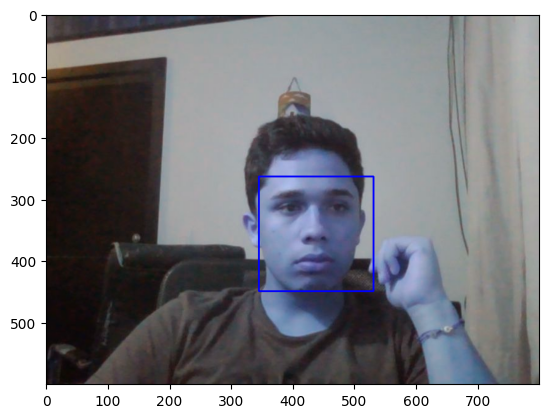

Reporte de asistencia con reconocimiento facial: 
Joshua  2023-11-22 07:24:42 


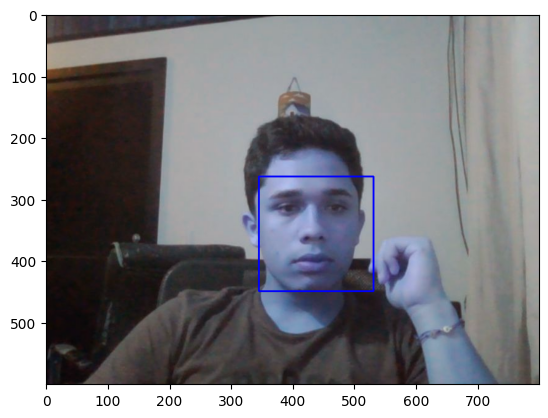

Reporte de asistencia con reconocimiento facial: 
Joshua  2023-11-22 07:24:44 


In [18]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''
i=0

match_info = []
path_cuadro = []
while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])
  # Get the face locations from the frame
  face_locations = face_recognition.face_locations(frame)

  img_path = '/content/drive/MyDrive/proyecto taller' + 'frame'+str(i)+'.jpg'
  cv2.imwrite(img_path ,frame)

  # For each face in the frame
  for (top, right, bottom, left) in face_locations:
      # Draw a rectangle around the face
      cv2.rectangle(
          frame,
          (left, top),
          (right, bottom),
          (0, 0, 255),
          2,
      )
      # Get the face encoding of the face
      face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

      # Compare the face encoding to the faces in the database
      matches = face_recognition.compare_faces(list(all_registered_faces.values()), face_encoding)

      # If there is a match
      if True in matches:
        if True in matches:
          faces_list = []
          for face_location in face_locations:  # Itera sobre las coordenadas de todas las caras
              top, right, bottom, left = face_location
              img_with_rectangle = cv2.rectangle(frame.copy(), (left, top), (right, bottom), (0, 255, 0), 2)
              face_rectangle = {'x1': left, 'y1': top, 'x2': right, 'y2': bottom}
              faces_list.append(face_rectangle)
              path_cuadro.append([img_path, faces_list])


              # Get the index of the match
              match_index = matches.index(True)
              # Get the name of the match
              match_name = list(registered_faces.keys())[match_index]

              current_time = datetime.now().strftime(" %Y-%m_%d %H:%M:%S ")
              match_info.append([match_name, path_cuadro, current_time])


              # Get the name of the match
              match_name = list(registered_faces.keys())[match_index]

              current_time = datetime.now().strftime(" %Y-%m-%d %H:%M:%S ")

              # Agrega la información a las listas
              match_info.append([match_name, img_path, current_time])
              path_cuadro.append([img_path, faces_list])
              with open("Assistance_report.bin", "ab") as f:
                report=AssistanceReport(match_name, path_cuadro, current_time )
                pickle.dump(report, f, pickle.HIGHEST_PROTOCOL)

  # Show image
  plt.imshow(frame)
  plt.show()
  print("Reporte de asistencia con reconocimiento facial: ")
  print(match_name, current_time)
  i+=1

<IPython.core.display.Javascript object>

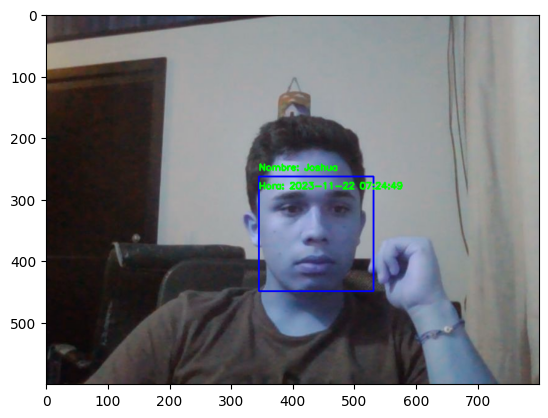

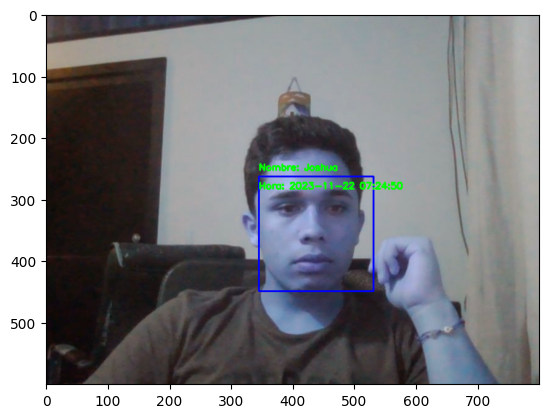

Joshua es la persona con más asistencias, asistió 2 veces al reporte.
Joshua es la persona con menos asistencias, asistió 2 veces al reporte.


In [19]:
import cv2
from datetime import datetime

# Inicializa algunas variables
video_stream()

label_html = 'Capturando...'
bbox = ''
i = 0
photo_count = 0
attendance_count = {}  # Diccionario para realizar un seguimiento de la asistencia

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convierte la respuesta de JS en una imagen de OpenCV
    frame = js_to_image(js_reply["img"])

    # Obtiene las ubicaciones de los rostros en el cuadro
    face_locations = face_recognition.face_locations(frame)

    img_path = '/content/drive/MyDrive/proyecto_taller' + 'frame' + str(i) + '.jpg'
    cv2.imwrite(img_path, frame)

    # Para cada rostro en el cuadro
    for (top, right, bottom, left) in face_locations:
        # Dibuja un rectángulo alrededor del rostro
        cv2.rectangle(
            frame,
            (left, top),
            (right, bottom),
            (0, 0, 255),
            2,
        )

        # Obtiene la codificación del rostro
        face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

        # Compara la codificación del rostro con la base de datos de rostros registrados
        matches = face_recognition.compare_faces(list(all_registered_faces.values()), face_encoding)

        # Si hay una coincidencia
        if True in matches:
            # Obtiene el índice de la coincidencia
            match_index = matches.index(True)

            # Obtiene el nombre de la persona reconocida
            match_name = list(all_registered_faces.keys())[match_index]

            # Obtiene la hora y fecha actual
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # Actualiza el contador de asistencia para esta persona
            if match_name in attendance_count:
                attendance_count[match_name] += 1
            else:
                attendance_count[match_name] = 1

            # Agrega texto a la imagen
            cv2.putText(frame, f"Nombre: {match_name}", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, f"Hora: {current_time}", (left, top + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Muestra la imagen
    plt.imshow(frame)
    plt.show()

    i +=1
    photo_count += 1

if attendance_count:
    most_attended_person = max(attendance_count, key=attendance_count.get)
    least_attended_person = min(attendance_count, key=attendance_count.get)
    most_attendances = attendance_count[most_attended_person]
    least_attendances = attendance_count[least_attended_person]
    print(f"{most_attended_person} es la persona con más asistencias, asistió {most_attendances} veces al reporte.")
    print(f"{least_attended_person} es la persona con menos asistencias, asistió {least_attendances} veces al reporte.")
else:
    print("No se reconoció a ninguna persona en el video.")